In [6]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
# from dynamic_routing_analysis import decoding_utils
# from dynamic_routing_analysis import plot_utils
# import dynamic_routing_analysis as dra
import pingouin as pg
import os
import random

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fm.FontProperties().set_family('arial')

%load_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib widget
# %matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# results_path="s3://aind-scratch-data/dynamic-routing/decoding/results/time_mod_keep_units_consistent_0/"

In [7]:
session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.268.csv"
# session_table_path="/Users/ethan.mcbride/Data/DR/session_table_v0.265.csv"
session_table=pl.read_csv(session_table_path)

dr_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')=="",
    # pl.col('is_engaged'),
    # pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )

In [8]:
predict_proba_pd = pd.read_parquet(r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\time_mod_keep_units_consistent_0_2025-06-15\predict_proba_by_session.parquet")


In [9]:
all_trials=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/trials.parquet').collect().to_pandas()
all_performance=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/performance.parquet').collect().to_pandas()

In [ ]:
# p(resp) versus p(vis context)
normalize_by_block=False
sel_project='DynamicRouting'
sel_unit_subsample_size=20
sel_bin_center=-0.25
unique_sessions=session_table.to_pandas().query('project==@sel_project')['session_id'].unique()

all_structures=[]

# #for each unique session
for ss,session_id in enumerate(unique_sessions):

    session_confidence=predict_proba_pd.query('session_id==@session_id and unit_subsample_size==@sel_unit_subsample_size and bin_center==@sel_bin_center')
    session_structures=session_confidence['structure'].unique()

    if len(session_confidence)==0:
        print(f'session_id {session_id} has no predict_proba data, skipping...')
        continue

    #load trials table & performance table
    trials=all_trials.query('session_id==@session_id')
    performance=all_performance.query('session_id==@session_id')

    if len(session_confidence['predict_proba'].iloc[0])!=len(trials):
        print(f'session_id {session_id} has different number of trials than predict_proba table, skipping...')
        continue

    #### How to normalize response rate by block/session?? ###

    # block_norm_response_rate=np.full(len(trials), np.nan)
    # add blockwise and session-wide performance to trials table
    for block_index in trials['block_index'].unique():
        block_performance=performance.query('block_index==@block_index')
        trials.loc[trials['block_index']==block_index,'block_dprime']=block_performance['cross_modality_dprime'].values[0]

        # block_trial_idx=trials.query('block_index==@block_index')['trial_index'].values
        # block_trials=trials.query('block_index==@block_index')
        # block_response_rate=block_trials['is_response'].mean()
        # session_response_rate=trials

    trials['session_dprime']=performance['cross_modality_dprime'].mean()
    trials['session_id']=session_id

    for structure in session_structures:
        # ss=session_structures[0]
        structure_confidence=session_confidence.query('structure==@structure')
        if len(structure_confidence)==0:
            continue
        structure_predict_proba=structure_confidence['predict_proba'].values[0]

        if normalize_by_block:
            block_normalized_predict_proba=np.full(len(trials), np.nan)
            for block_index in trials['block_index'].unique():
                block_trial_idx=trials.query('block_index==@block_index')['trial_index'].values
                block_normalized_predict_proba[block_trial_idx]=structure_predict_proba[block_trial_idx]-np.nanmean(structure_predict_proba[block_trial_idx])

            # trials[structure+'_predict_proba']=structure_predict_proba
            trials[structure+'_predict_proba']=block_normalized_predict_proba
        else:
            trials[structure+'_predict_proba']=structure_predict_proba

        if structure not in all_structures:
            all_structures.append(structure)

    if ss==0:
        all_trials_with_decoder_confidence=trials
    else:
        all_trials_with_decoder_confidence=pd.concat([all_trials_with_decoder_confidence,trials],axis=0,ignore_index=True)
        
# all_trials_with_decoder_confidence.to_parquet(
#     r'\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\time_mod_keep_units_consistent_0_2025-06-15\all_trials_with_predict_proba.parquet')


In [10]:
all_trials_with_decoder_confidence = pd.read_parquet(
    r'\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\time_mod_keep_units_consistent_0_2025-06-15\all_trials_with_predict_proba.parquet')

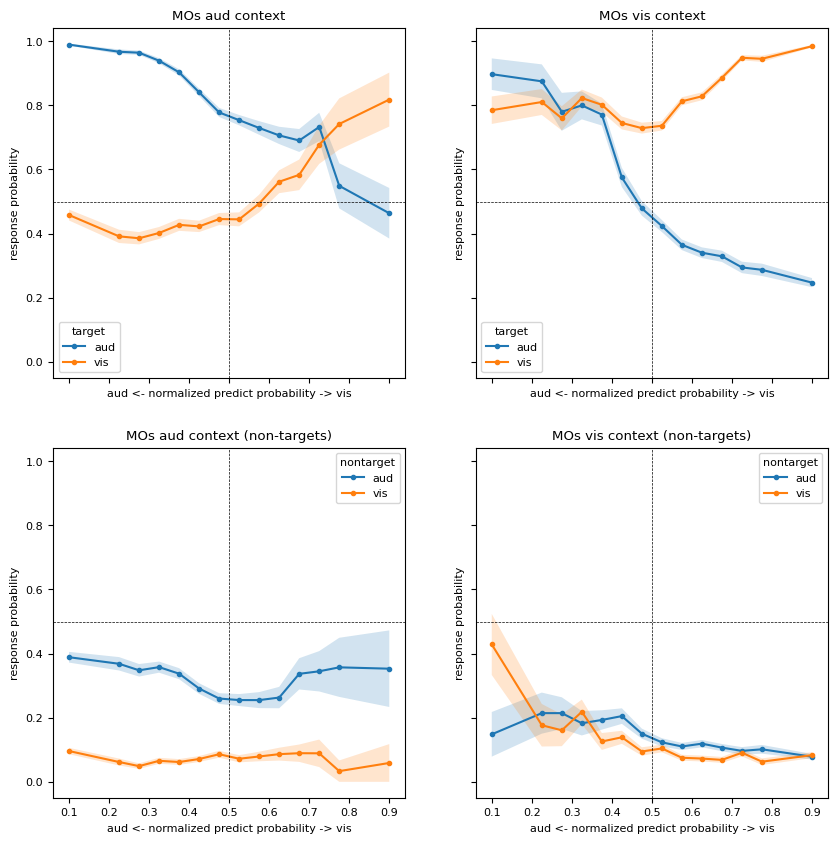

In [11]:
figsavepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-07-02-predict_proba_vs_response_rate_normalized\raw_predict_proba"
# sel_structure='SCm'

unique_areas=predict_proba_pd['structure'].unique()

targets=['aud','vis']
contexts=['aud','vis']
# dprime_threshold=1.0

normalize_by_block=False

if normalize_by_block:
    conf_bins=np.array([-1.0,-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4,1.0])
else:
    conf_bins=np.array([0,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,1.0])

conf_bin_midpoints=conf_bins[:-1]+np.diff(conf_bins)/2

for sel_structure in unique_areas:
    sel_structure='MOs'

    fig,ax=plt.subplots(2,2,figsize=(10,10),sharex=True,sharey=True)

    for sel_context in contexts:

        if sel_context=='aud':
            axind=0
        elif sel_context=='vis':
            axind=1

        for sel_target in targets:

            structure_predict_proba=all_trials_with_decoder_confidence.query('is_'+sel_context+'_rewarded and is_'+sel_target+'_target')[[sel_structure+'_predict_proba','is_response']]
            structure_predict_proba_nontarget=all_trials_with_decoder_confidence.query('is_'+sel_context+'_rewarded and is_'+sel_target+'_nontarget')[[sel_structure+'_predict_proba','is_response']]
            # structure_predict_proba=all_trials_with_decoder_confidence.query('is_'+sel_context+'_rewarded and is_'+sel_target+'_target and block_dprime>=@dprime_threshold')[[sel_structure+'_predict_proba','is_response']]

            predict_proba_bins=pd.cut(structure_predict_proba[sel_structure+'_predict_proba'],bins=conf_bins,labels=False)
            structure_predict_proba['predict_proba_bins']=predict_proba_bins

            structure_predict_proba_nontarget['predict_proba_bins']=pd.cut(structure_predict_proba_nontarget[sel_structure+'_predict_proba'],bins=conf_bins,labels=False)

            #mean values for targets
            mean_bin_values=[]
            bin_sems=[]
            #mean values for non-targets
            mean_bin_values_nontargets=[]
            bin_sems_nontargets=[]

            for bb in range(len(conf_bins[:-1])):
                bin_data=structure_predict_proba.query('predict_proba_bins==@bb')
                mean_bin_values.append(np.nanmean(bin_data['is_response']))
                bin_sems.append(stats.sem(bin_data['is_response'],nan_policy='omit'))
                #mean values for non-targets
                bin_data_nontargets=structure_predict_proba_nontarget.query('predict_proba_bins==@bb')
                mean_bin_values_nontargets.append(np.nanmean(bin_data_nontargets['is_response']))
                bin_sems_nontargets.append(stats.sem(bin_data_nontargets['is_response'],nan_policy='omit'))


            # ax.errorbar(conf_bin_midpoints,mean_bin_values,yerr=bin_sems,marker='.')
            ax[0,axind].plot(conf_bin_midpoints,mean_bin_values,marker='.',label=sel_target)
            ax[0,axind].fill_between(conf_bin_midpoints,np.array(mean_bin_values)-np.array(bin_sems),np.array(mean_bin_values)+np.array(bin_sems),alpha=0.2)
            ax[0,axind].set_xlabel('aud <- normalized predict probability -> vis')
            ax[0,axind].set_ylabel('response probability')
            ax[0,axind].set_title(sel_structure+' '+sel_context+' context')

            ax[1,axind].plot(conf_bin_midpoints,mean_bin_values_nontargets,marker='.',label=sel_target)
            ax[1,axind].fill_between(conf_bin_midpoints,np.array(mean_bin_values_nontargets)-np.array(bin_sems_nontargets),np.array(mean_bin_values_nontargets)+np.array(bin_sems_nontargets),alpha=0.2)
            ax[1,axind].set_xlabel('aud <- normalized predict probability -> vis')
            ax[1,axind].set_ylabel('response probability')
            ax[1,axind].set_title(sel_structure+' '+sel_context+' context (non-targets)')
        
        if normalize_by_block:
            ax[0,axind].axvline(0,color='k',linewidth=0.5,linestyle='--')
            ax[1,axind].axvline(0,color='k',linewidth=0.5,linestyle='--')
        else:
            ax[0,axind].axvline(0.5,color='k',linewidth=0.5,linestyle='--')
            ax[1,axind].axvline(0.5,color='k',linewidth=0.5,linestyle='--')
            
        ax[0,axind].axhline(0.5,color='k',linewidth=0.5,linestyle='--')
        ax[0,axind].legend(title='target')

        ax[1,axind].axhline(0.5,color='k',linewidth=0.5,linestyle='--')
        ax[1,axind].legend(title='nontarget')

    break

    # fig.suptitle(f"{sel_structure} predict proba vs response rate; bin center={sel_bin_center}; unit subsample size={sel_unit_subsample_size}; normalize_by_block={normalize_by_block}")
    # fig.tight_layout()
    # fig.savefig(os.path.join(figsavepath,f"{sel_structure.replace('/','-')}_predict_proba_vs_response_rate_normalized.png"), dpi=300)
    # plt.close(fig)



In [ ]:
session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.268.csv"
# session_table_path="/Users/ethan.mcbride/Data/DR/session_table_v0.265.csv"
session_table=pl.read_csv(session_table_path)
session_table.to_pandas()#.query('project==@sel_project')['session_id'].unique()

In [12]:
#plot in tiers of performance
sel_project='DynamicRouting'

#get average cross modal dprime per session
session_dprime_table={
    'session_id':[],
    'cross_modality_dprime':[],
    'non_rewarded_target_response_rate':[],
    'rewarded_target_response_rate':[],
    'n_blocks_1_0':[],
    'n_blocks_1_5':[],
    'n_blocks_2_0':[],
}

for session_id in all_performance['session_id'].unique():
    if len(session_table.to_pandas().query('session_id==@session_id'))==0:
        continue
    if session_table.to_pandas().query('session_id==@session_id')['project'].values[0] != sel_project:
        continue
    if session_table.to_pandas().query('session_id==@session_id')['is_engaged'].values[0] == False:
        continue
    session_performance=all_performance.query('session_id==@session_id')
    session_dprime_table['session_id'].append(session_id)
    session_dprime_table['cross_modality_dprime'].append(session_performance['cross_modality_dprime'].mean())
    session_dprime_table['n_blocks_1_0'].append(session_performance.query('cross_modality_dprime>=1.0').shape[0])
    session_dprime_table['n_blocks_1_5'].append(session_performance.query('cross_modality_dprime>=1.5').shape[0])
    session_dprime_table['n_blocks_2_0'].append(session_performance.query('cross_modality_dprime>=2.0').shape[0])
    
    non_rewarded_response_rate=[]
    rewarded_response_rate=[]
    for bb,block in session_performance.iterrows():
        if block['rewarded_modality']=='vis':
            non_rewarded_response_rate.append(block['aud_target_response_rate'])
            rewarded_response_rate.append(block['vis_target_response_rate'])
        elif block['rewarded_modality']=='aud':
            non_rewarded_response_rate.append(block['vis_target_response_rate'])
            rewarded_response_rate.append(block['aud_target_response_rate'])

    session_dprime_table['non_rewarded_target_response_rate'].append(np.mean(non_rewarded_response_rate))
    session_dprime_table['rewarded_target_response_rate'].append(np.mean(rewarded_response_rate))

session_dprime_df=pd.DataFrame(session_dprime_table)
session_dprime_df

,session_id,cross_modality_dprime,non_rewarded_target_response_rate,rewarded_target_response_rate,n_blocks_1_0,n_blocks_1_5,n_blocks_2_0
0,626791_2022-08-15,1.705494,0.540387,1.000000,5,3,2
1,626791_2022-08-16,1.308840,0.612817,0.928793,5,3,1
2,626791_2022-08-17,1.144424,0.729357,0.981481,3,3,1
3,636766_2023-01-23,1.965732,0.457631,0.969281,5,5,3
4,636766_2023-01-24,1.865015,0.335580,0.846991,5,4,3
...,...,...,...,...,...,...,...
166,761583_2024-12-20,1.980356,0.440486,0.991228,6,5,3
167,762526_2025-03-18,0.486045,0.620440,0.760746,2,1,0
168,762526_2025-03-19,0.809019,0.570663,0.732198,3,3,0
169,762526_2025-03-20,1.107200,0.374561,0.695078,2,2,2


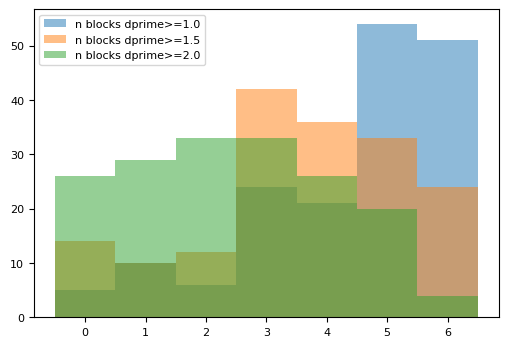

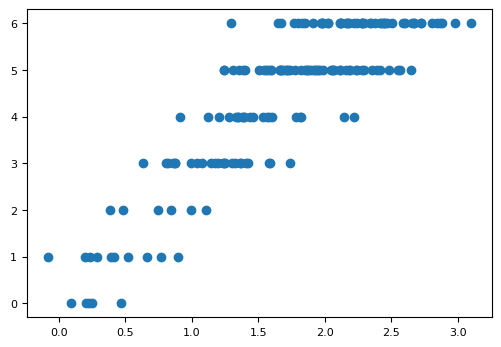

In [13]:
fig,ax=plt.subplots(1,1,figsize=(6,4))
ax.hist(session_dprime_df['n_blocks_1_0'],bins=np.arange(-0.5,7.5,1),alpha=0.5,label='n blocks dprime>=1.0')
ax.hist(session_dprime_df['n_blocks_1_5'],bins=np.arange(-0.5,7.5,1),alpha=0.5,label='n blocks dprime>=1.5')
ax.hist(session_dprime_df['n_blocks_2_0'],bins=np.arange(-0.5,7.5,1),alpha=0.5,label='n blocks dprime>=2.0')
ax.legend()

fig,ax=plt.subplots(1,1,figsize=(6,4))
ax.scatter(session_dprime_df['cross_modality_dprime'], session_dprime_df['n_blocks_1_0'], label='n blocks dprime>=1.0')

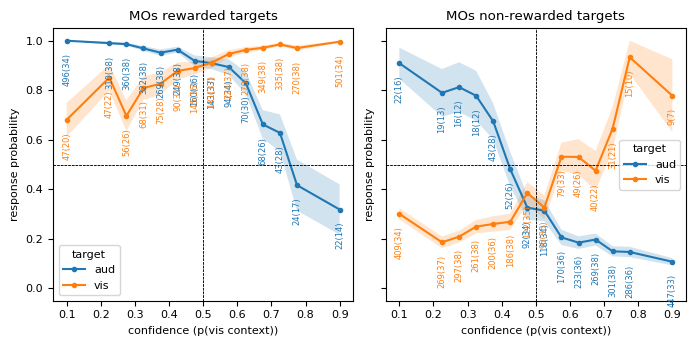

In [14]:
#plot nonrewarded targets together and rewarded targets together

# sel_structure='MOs'
# savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-09-23-response_prob_vs_decoder_confidence_simplified"

# struct_list=['VISp','AUDp','ACAd','AId','MOs','MOp','SSp','SSs','ORBl','PL','SCm','MRN','CP','MD','RT','VM','GPe']
struct_list=['MOs']

# good_behavior_only=True
# if good_behavior_only:
#     sel_sessions=dr_session_list
# else:
#     sel_sessions=all_session_list

sel_sessions=session_dprime_df.query('cross_modality_dprime >= 2')['session_id'].unique()

targets=['aud','vis']
rewarded=[True,False]
# contexts=['aud','vis']
# dprime_threshold=1.0
conf_bins=np.array([0,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,1.0])
conf_bin_midpoints=conf_bins[:-1]+np.diff(conf_bins)/2

for sel_structure in struct_list:

    fig,ax=plt.subplots(1,2,figsize=(7,3.5),sharex=True,sharey=True)

    for rr, is_rewarded in enumerate(rewarded):

        if is_rewarded:
            ax[rr].set_title(sel_structure+' rewarded targets')
        else:
            ax[rr].set_title(sel_structure+' non-rewarded targets')
        for sel_target in targets:

            structure_predict_proba=all_trials_with_decoder_confidence.query(
                'is_'+sel_target+'_target and is_'+sel_target+'_rewarded==@is_rewarded and session_id in @sel_sessions')[[sel_structure+'_predict_proba','is_response','session_id']]

            predict_proba_bins=pd.cut(structure_predict_proba[sel_structure+'_predict_proba'],bins=conf_bins,labels=False)
            structure_predict_proba['predict_proba_bins']=predict_proba_bins

            #mean values for targets
            mean_bin_values=[]
            bin_sems=[]
            n_trials=[]
            n_sessions=[]

            for bb in range(len(conf_bins[:-1])):
                bin_data=structure_predict_proba.query('predict_proba_bins==@bb')
                mean_bin_values.append(np.nanmean(bin_data['is_response']))
                bin_sems.append(stats.sem(bin_data['is_response'],nan_policy='omit'))
                n_trials.append(len(bin_data))
                n_sessions.append(len(bin_data['session_id'].unique()))


            line=ax[rr].plot(conf_bin_midpoints,mean_bin_values,marker='.',label=sel_target)
            for bb in range(len(conf_bin_midpoints)):
                ax[rr].text(conf_bin_midpoints[bb], mean_bin_values[bb]-0.05, str(n_trials[bb])+'('+str(n_sessions[bb])+')', 
                            ha='center', va='top', fontsize=6, color=line[0].get_color(), rotation=90)
            ax[rr].fill_between(conf_bin_midpoints,np.array(mean_bin_values)-np.array(bin_sems),np.array(mean_bin_values)+np.array(bin_sems),alpha=0.2)
            ax[rr].set_xlabel('confidence (p(vis context))')
            ax[rr].set_ylabel('response probability')
            # ax.set_title(sel_structure)

            ax[rr].axvline(0.5,color='k',linewidth=0.5,linestyle='--')
            ax[rr].axhline(0.5,color='k',linewidth=0.5,linestyle='--')
            ax[rr].legend(title='target')

            ax[rr].set_ylim([-0.05,1.05])

    fig.tight_layout()
    # fig.savefig(os.path.join(savepath,sel_structure+'_response_prob_vs_decoder_confidence_fixed_yaxis.pdf'),dpi=300)
    # plt.close(fig)





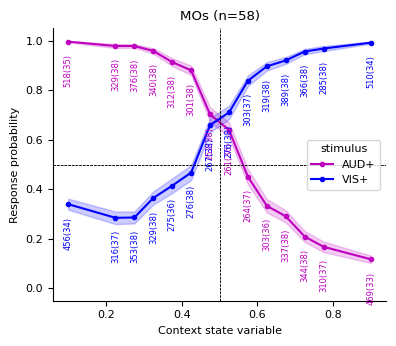

In [29]:
#plot all targets combined

# sel_structure='MOs'
savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-11-10-plots_for_SFN_poster"

# struct_list=['VISp','AUDp','ACAd','AId','MOs','MOp','SSp','SSs','ORBl','PL','SCm','MRN','CP','MD','RT','VM','GPe']
struct_list=['MOs']

# good_behavior_only=True
# if good_behavior_only:
#     sel_sessions=dr_session_list
# else:
#     sel_sessions=all_session_list

sel_sessions=session_dprime_df.query('cross_modality_dprime >= 2')['session_id'].unique()

targets=['aud','vis']
target_names=['AUD+','VIS+']

# contexts=['aud','vis']
# dprime_threshold=1.0
conf_bins=np.array([0,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,1.0])
conf_bin_midpoints=conf_bins[:-1]+np.diff(conf_bins)/2

for sel_structure in struct_list:

    fig,ax=plt.subplots(1,1,figsize=(4,3.5))

    for tt,sel_target in enumerate(targets):
        
        if sel_target=='aud':
            set_color='m'
        elif sel_target=='vis':
            set_color='b'

        structure_predict_proba=all_trials_with_decoder_confidence.query(
            'is_'+sel_target+'_target and session_id in @sel_sessions')[[sel_structure+'_predict_proba','is_response','session_id']]

        predict_proba_bins=pd.cut(structure_predict_proba[sel_structure+'_predict_proba'],bins=conf_bins,labels=False)
        structure_predict_proba['predict_proba_bins']=predict_proba_bins

        #mean values for targets
        mean_bin_values=[]
        bin_sems=[]
        n_trials=[]
        n_sessions=[]

        for bb in range(len(conf_bins[:-1])):
            bin_data=structure_predict_proba.query('predict_proba_bins==@bb')
            mean_bin_values.append(np.nanmean(bin_data['is_response']))
            bin_sems.append(stats.sem(bin_data['is_response'],nan_policy='omit'))
            n_trials.append(len(bin_data))
            n_sessions.append(len(bin_data['session_id'].unique()))


        line=ax.plot(conf_bin_midpoints,mean_bin_values,marker='.',label=target_names[tt],color=set_color)
        for bb in range(len(conf_bin_midpoints)):
            ax.text(conf_bin_midpoints[bb], mean_bin_values[bb]-0.05, str(n_trials[bb])+'('+str(n_sessions[bb])+')', 
                        ha='center', va='top', fontsize=6, color=line[0].get_color(), rotation=90)
        ax.fill_between(conf_bin_midpoints,np.array(mean_bin_values)-np.array(bin_sems),np.array(mean_bin_values)+np.array(bin_sems),alpha=0.2,
                        color=set_color)
        ax.set_xlabel('Context state variable')
        ax.set_ylabel('Response probability')
        # ax.set_title(sel_structure)

        ax.axvline(0.5,color='k',linewidth=0.5,linestyle='--')
        ax.axhline(0.5,color='k',linewidth=0.5,linestyle='--')
        ax.legend(title='stimulus')

        ax.set_ylim([-0.05,1.05])

        n_sessions=len(structure_predict_proba['session_id'].unique())

        ax.set_title(sel_structure+' (n='+str(n_sessions)+')')

        #remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ax.set_xticks([0.2,0.4,0.6,0.8])

    fig.tight_layout()
    # fig.savefig(os.path.join(savepath,sel_structure+'_response_prob_vs_decoder_confidence_fixed_yaxis.pdf'),dpi=300)
    # plt.close(fig)






Text(0, 0.5, 'number of sessions')

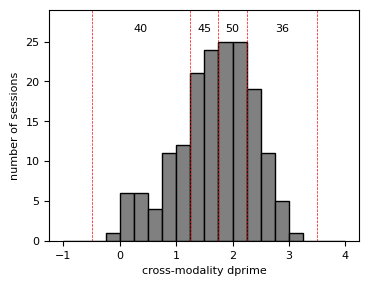

In [15]:
#get n sessions in each bin
# performance_bins=[-0.5,0.5,1.0,1.5,2.0,2.5,3.5]
# performance_bins=[-0.5,0.25,0.75,1.25,1.75,2.25,3.5]
performance_bins=[-0.5,1.25,1.75,2.25,3.5]
# performance_bins=[-0.5,1,1.5,2.0,3.5]
n_sessions_per_bin = []

sessions_by_dprime={
    'dprime_bin':[],
    'session_ids':[],
}

for bb,bin in enumerate(performance_bins[:-1]):
    n_sessions = np.sum((session_dprime_df['cross_modality_dprime'] >= bin) & (session_dprime_df['cross_modality_dprime'] < performance_bins[bb+1]))
    n_sessions_per_bin.append(n_sessions)
    sessions_in_bin=session_dprime_df.query('cross_modality_dprime>=@bin and cross_modality_dprime<@performance_bins[@bb+1]')['session_id'].values
    sessions_by_dprime['dprime_bin'].append(f"{np.round(bin, 2)}-{np.round(performance_bins[bb+1], 2)}")
    sessions_by_dprime['session_ids'].append(sessions_in_bin)

xbins=np.arange(-1.0,4.0+.1,0.25)
fig,ax=plt.subplots(1,1,figsize=(4,3))
counts, bins, patches=ax.hist(session_dprime_df['cross_modality_dprime'], bins=xbins, color='gray', edgecolor='black')

for bb,bin in enumerate(performance_bins):
    if bb < len(performance_bins)-1:
        bin_label=f"{bin}-{performance_bins[bb+1]}"
        bin_center=(bin+performance_bins[bb+1])/2
        ax.text(bin_center, np.max(counts)+1, str(n_sessions_per_bin[bb]), ha='center', va='bottom')
    ax.axvline(x=bin, color='red', linestyle='--', linewidth=0.5)

ax.set_ylim(0, np.max(counts)+4)
ax.set_xlabel('cross-modality dprime')
ax.set_ylabel('number of sessions')

In [ ]:
#get n sessions in each bin
# performance_bins=[-0.5,0.5,1.0,1.5,2.0,2.5,3.5]
# false_alarm_bins=np.arange(0,1.05,0.2)
false_alarm_bins=[0,0.3,0.45,0.65,1.0]
n_sessions_per_bin = []

sessions_by_fa_rate={
    'fa_bin':[],
    'session_ids':[],
}

for bb,bin in enumerate(false_alarm_bins[:-1]):
    n_sessions = np.sum((session_dprime_df['non_rewarded_target_response_rate'] >= bin) & (session_dprime_df['non_rewarded_target_response_rate'] < false_alarm_bins[bb+1]))
    n_sessions_per_bin.append(n_sessions)
    session_ids_in_bin=session_dprime_df.query('non_rewarded_target_response_rate >= @bin and non_rewarded_target_response_rate < @false_alarm_bins[@bb+1]')['session_id'].values
    sessions_by_fa_rate['fa_bin'].append(f"{np.round(bin, 2)}-{np.round(false_alarm_bins[bb+1], 2)}")
    sessions_by_fa_rate['session_ids'].append(session_ids_in_bin)

xbins=np.arange(0,1.0+.05,0.05)
fig,ax=plt.subplots(1,1,figsize=(4,3))
counts, bins, patches=ax.hist(session_dprime_df['non_rewarded_target_response_rate'], bins=xbins, color='gray', edgecolor='black')

for bb,bin in enumerate(false_alarm_bins):
    if bb < len(false_alarm_bins)-1:
        bin_label=f"{bin}-{false_alarm_bins[bb+1]}"
        bin_center=(bin+false_alarm_bins[bb+1])/2
        ax.text(bin_center, np.max(counts)+1, str(n_sessions_per_bin[bb]), ha='center', va='bottom')
    ax.axvline(x=bin, color='red', linestyle='--', linewidth=0.5)

ax.set_ylim(0, np.max(counts)+4)
ax.set_xlabel('non-rewarded target response rate')
ax.set_ylabel('number of sessions')

In [ ]:
#plot nonrewarded targets together and rewarded targets together
# group by performance

# sel_structure='MOs'
# savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-09-23-response_prob_vs_decoder_confidence_simplified"

# struct_list=['VISp','AUDp','ACAd','AId','MOs','MOp','SSp','SSs','ORBl','PL','SCm','MRN','CP','MD','RT','VM','GPe']
struct_list=['MOs']
targets=['aud','vis']
rewarded=[True,False]
# contexts=['aud','vis']
# dprime_threshold=1.0
# conf_bins=np.array([0,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,1.0])
conf_bins=np.array([0,0.25,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.75,1.0])
conf_bin_midpoints=conf_bins[:-1]+np.diff(conf_bins)/2

session_df=pd.DataFrame(sessions_by_dprime) #sessions_by_fa_rate

for sel_structure in struct_list:
    fig,ax=plt.subplots(len(session_df),2,figsize=(6,10),sharex=True,sharey=True)

    for ss,session_df_row in session_df.iterrows():
        sel_sessions=session_df_row['session_ids']
        performance_bin=session_df_row['dprime_bin']

        for rr, is_rewarded in enumerate(rewarded):

            if is_rewarded:
                ax[ss,rr].set_title(sel_structure+' rewarded targets\ncross-modal dprime range = '+performance_bin)
            else:
                ax[ss,rr].set_title(sel_structure+' non-rewarded targets\ncross-modal dprime range = '+performance_bin)
            for sel_target in targets:

                structure_predict_proba=all_trials_with_decoder_confidence.query(
                    'is_'+sel_target+'_target and is_'+sel_target+'_rewarded==@is_rewarded and session_id in @sel_sessions')[[sel_structure+'_predict_proba','is_response','session_id']]

                predict_proba_bins=pd.cut(structure_predict_proba[sel_structure+'_predict_proba'],bins=conf_bins,labels=False)
                structure_predict_proba['predict_proba_bins']=predict_proba_bins

                #mean values for targets
                mean_bin_values=[]
                bin_sems=[]
                n_trials=[]
                n_sessions=[]

                for bb in range(len(conf_bins[:-1])):
                    bin_data=structure_predict_proba.query('predict_proba_bins==@bb')
                    mean_bin_values.append(np.nanmean(bin_data['is_response']))
                    bin_sems.append(stats.sem(bin_data['is_response'],nan_policy='omit'))
                    n_trials.append(len(bin_data))
                    n_sessions.append(len(bin_data['session_id'].unique()))

                line=ax[ss,rr].plot(conf_bin_midpoints,mean_bin_values,marker='.',label=sel_target)
                ax[ss,rr].fill_between(conf_bin_midpoints,np.array(mean_bin_values)-np.array(bin_sems),np.array(mean_bin_values)+np.array(bin_sems),alpha=0.2)
                #plot n_trials below each point
                for bb in range(len(conf_bin_midpoints)):
                    ax[ss,rr].text(conf_bin_midpoints[bb], mean_bin_values[bb]-0.05, str(n_trials[bb])+'('+str(n_sessions[bb])+')', ha='center', va='top', fontsize=6, color=line[0].get_color())

                if ss==len(session_df)-1:
                    ax[ss,rr].set_xlabel('confidence (p(vis context))')
                if rr==0:
                    ax[ss,rr].set_ylabel('response probability')
                # ax.set_title(sel_structure)

                ax[ss,rr].axvline(0.5,color='k',linewidth=0.5,linestyle='--')
                ax[ss,rr].axhline(0.5,color='k',linewidth=0.5,linestyle='--')
                ax[ss,rr].legend(title='target')

                ax[ss,rr].set_ylim([-0.05,1.05])


        # fig.suptitle(f"performance range = {performance_bin}")
        fig.tight_layout()
    # fig.savefig(os.path.join(savepath,sel_structure+'_response_prob_vs_decoder_confidence_fixed_yaxis.pdf'),dpi=300)
    # plt.close(fig)





In [ ]:
#plot nonrewarded targets together and rewarded targets together
# group by performance

# sel_structure='MOs'
# savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-09-23-response_prob_vs_decoder_confidence_simplified"

# struct_list=['VISp','AUDp','ACAd','AId','MOs','MOp','SSp','SSs','ORBl','PL','SCm','MRN','CP','MD','RT','VM','GPe']
struct_list=['MOs']
targets=['aud','vis']
rewarded=[True,False]
# contexts=['aud','vis']
# dprime_threshold=1.0
# conf_bins=np.array([0,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,1.0])
conf_bins=np.array([0,0.25,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.75,1.0])
conf_bin_midpoints=conf_bins[:-1]+np.diff(conf_bins)/2

session_df=pd.DataFrame(sessions_by_fa_rate) #sessions_by_fa_rate

for sel_structure in struct_list:
    fig,ax=plt.subplots(len(session_df),2,figsize=(6,10),sharex=True,sharey=True)

    for ss,session_df_row in session_df.iterrows():
        sel_sessions=session_df_row['session_ids']
        performance_bin=session_df_row['fa_bin']

        for rr, is_rewarded in enumerate(rewarded):

            if is_rewarded:
                ax[ss,rr].set_title(sel_structure+' rewarded targets\nfa range = '+performance_bin)
            else:
                ax[ss,rr].set_title(sel_structure+' non-rewarded targets\nfa range = '+performance_bin)
            for sel_target in targets:

                structure_predict_proba=all_trials_with_decoder_confidence.query(
                    'is_'+sel_target+'_target and is_'+sel_target+'_rewarded==@is_rewarded and session_id in @sel_sessions')[[sel_structure+'_predict_proba','is_response']]

                predict_proba_bins=pd.cut(structure_predict_proba[sel_structure+'_predict_proba'],bins=conf_bins,labels=False)
                structure_predict_proba['predict_proba_bins']=predict_proba_bins

                #mean values for targets
                mean_bin_values=[]
                bin_sems=[]

                for bb in range(len(conf_bins[:-1])):
                    bin_data=structure_predict_proba.query('predict_proba_bins==@bb')
                    mean_bin_values.append(np.nanmean(bin_data['is_response']))
                    bin_sems.append(stats.sem(bin_data['is_response'],nan_policy='omit'))

                ax[ss,rr].plot(conf_bin_midpoints,mean_bin_values,marker='.',label=sel_target)
                ax[ss,rr].fill_between(conf_bin_midpoints,np.array(mean_bin_values)-np.array(bin_sems),np.array(mean_bin_values)+np.array(bin_sems),alpha=0.2)
                if ss==len(session_df)-1:
                    ax[ss,rr].set_xlabel('confidence (p(vis context))')
                if rr==0:
                    ax[ss,rr].set_ylabel('response probability')
                # ax.set_title(sel_structure)

                ax[ss,rr].axvline(0.5,color='k',linewidth=0.5,linestyle='--')
                ax[ss,rr].axhline(0.5,color='k',linewidth=0.5,linestyle='--')
                ax[ss,rr].legend(title='target')

                ax[ss,rr].set_ylim([-0.05,1.05])


        # fig.suptitle(f"performance range = {performance_bin}")
        fig.tight_layout()
    # fig.savefig(os.path.join(savepath,sel_structure+'_response_prob_vs_decoder_confidence_fixed_yaxis.pdf'),dpi=300)
    # plt.close(fig)



